In [1]:
import utils.classification_utils as evaluation
import utils.utils as utils

import pandas as pd
import seaborn as sns
import IPython.display as ipd
import matplotlib.pyplot as plt

from dotenv import load_dotenv
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

load_dotenv()
sns.set_palette("Set2")

# 1. Defining the task and splitting the data
The goal is to see how a baseline model such as Naive Bayes performs on the challenging task of genre classification.
Since Naive Bayes is a generative classifier, we need to specify a form for the class conditional density $$p(\mathbf{x}|y=c,\mathbf{\theta})$$ Which in this case we will assume that $$p(\mathbf{x}|y=c,\mathbf{\theta}) = \prod_{j=1}^{D} \mathcal{N}(x_j|\mu_{jc}, \sigma_{jc}^2)$$
And hence we will use the GaussianNB model from sklearn.


We will fit the models on different feature subsets (or transformations of the features) and analyse their results on the test set.

In [2]:
df = pd.read_csv(FEATURES_PATH_PROCESSED, index_col=0, header=[0, 1, 2])

# Genre column has no inner levels
df = df.rename(columns={'Unnamed: 253_level_1': '', 'Unnamed: 253_level_2' : ''})

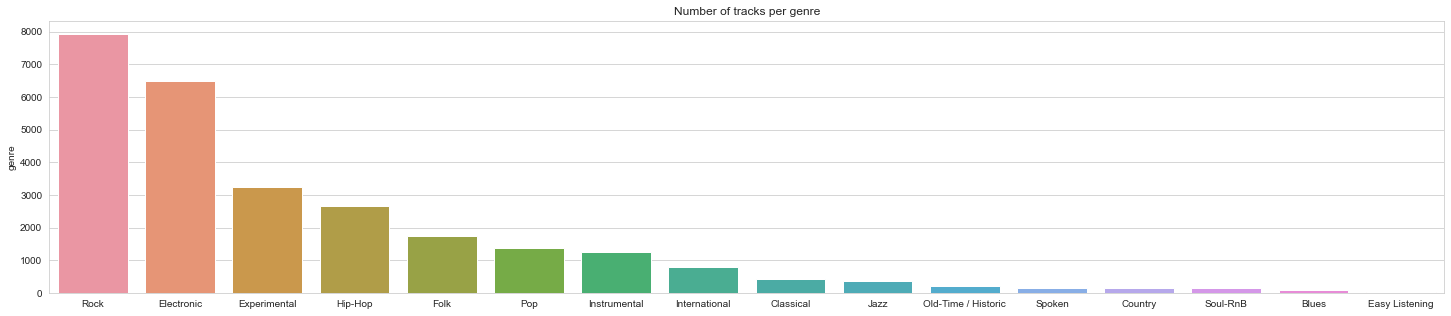

In [3]:
plt.figure(figsize=(25, 5))
sns.barplot(x=df['genre'].value_counts().index, y=df['genre'].value_counts())
plt.title('Number of tracks per genre')
plt.show()

## 1.1 Train, test split

In [4]:
train_set, test_set = train_test_split(df, test_size=0.2, stratify=df['genre'], random_state=123)

train_value_counts = train_set['genre'].value_counts(normalize=True) * 100.0
test_value_counts = test_set['genre'].value_counts(normalize=True) * 100.0

train_value_counts.name = 'train %'
test_value_counts.name = 'test %'

train_set_indexes = train_set.index
test_set_indexes = test_set.index

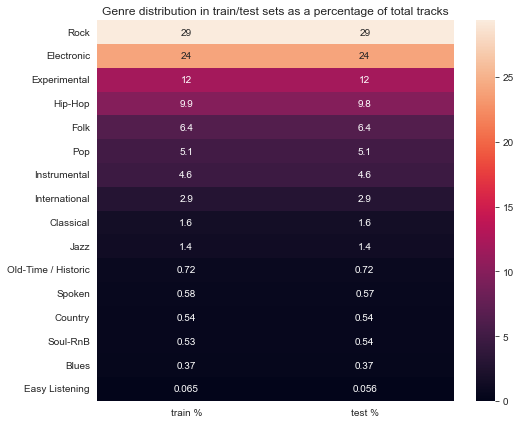

In [5]:
plt.figure(figsize=(8, 7))
sns.heatmap(
    pd.concat([train_value_counts, test_value_counts], axis=1),
    annot=True,
    vmin=0
)
plt.title("Genre distribution in train/test sets as a percentage of total tracks")
plt.show()

## 1.2 Feature subsets (same as decision_trees notebook)

1. df_1 contains only MFCC features
2. df_2 contains [‘mfcc’, ‘spectral_centroid’, ‘spectral_contrast’, ‘rmse’, ‘tonnetz’, ‘zcr’, ‘chroma_cqt’] features (with some changes)
3. df_3 is the result of applying PCA to df_2

In [6]:
def scale_data(train_X, test_X, scaler):
    train_X = train_X.copy()
    test_X = test_X.copy()

    train_X = pd.DataFrame(scaler.fit_transform(train_X), index=train_X.index, columns=train_X.columns)
    test_X = pd.DataFrame(scaler.transform(test_X), index=test_X.index, columns=test_X.columns)

    return train_X, test_X

In [7]:
# df_1:
# MFCCs are considered to be highly informative, so it is worth trying to build a model using only these features
df_1 = df['mfcc'].copy()


# df_2:
# We select only spectral_centroid because of the high correlation with spectral_bandwidth and spectral_rolloff
slice_1 = pd.IndexSlice[['mfcc', 'spectral_centroid', 'spectral_contrast', 'rmse', 'tonnetz', 'zcr']]

# Select all features of chroma_cqt, except max (most of the values are 1s)
slice_2 = pd.IndexSlice['chroma_cqt', ('kurtosis', 'mean', 'median', 'min', 'skew', 'std')]
df_2 = pd.concat([df.loc[:, slice_1], df.loc[:, slice_2]], axis=1).copy()


# df_3
# To prevent leakage of information from the and test set
df_3_train = df_2.loc[train_set_indexes, :].copy()
df_3_test = df_2.loc[test_set_indexes, :].copy()

# Scaling the features before applying PCA
df_3_train, df_3_test = scale_data(df_3_train, df_3_test, StandardScaler())

# Select the number of components such that the amount of variance that needs to be explained is greater than 95%
pca = PCA(n_components=0.95)
df_3_train = pd.DataFrame(pca.fit_transform(df_3_train), index=df_3_train.index)
df_3_test = pd.DataFrame(pca.transform(df_3_test), index=df_3_test.index)

In [8]:
datasets_X = {
    'df_1' : {
        'train' : df_1.loc[train_set_indexes, :],
        'test' : df_1.loc[test_set_indexes, :],
    },
    'df_2' : {
        'train' : df_2.loc[train_set_indexes, :],
        'test' : df_2.loc[test_set_indexes, :],
    },
    'df_3' : {
        'train' : df_3_train,
        'test' : df_3_test
    },
}

print('dataset (train rows, train columns) (test rows, test columns)')
for name, dataset in datasets_X.items():
    print(name, dataset['train'].shape, dataset['test'].shape)

dataset (train rows, train columns) (test rows, test columns)
df_1 (21607, 140) (5402, 140)
df_2 (21607, 324) (5402, 324)
df_3 (21607, 150) (5402, 150)


# 2. Training and evaluating the models

In [9]:
from sklearn.naive_bayes import GaussianNB

In [10]:
models = {}

for model_name, dataset_X in datasets_X.items():
    gnb = GaussianNB()

    train_X = dataset_X['train']
    train_y = df.loc[train_set_indexes, 'genre']

    gnb.fit(train_X, train_y)
    models[model_name] = gnb

In [11]:
model_evaluations = {}
for model_name, model in models.items():
    train_X = datasets_X[model_name]['train']
    train_y = df.loc[train_set_indexes, 'genre']

    test_X = datasets_X[model_name]['test']
    test_y = df.loc[test_set_indexes, 'genre']

    me = ClassificationEvaluation(
        model_name=model_name,
        model=model,
        train_X=train_X,
        train_y=train_y,
        val_X=test_X,
        val_y=test_y
    )

    model_evaluations[model_name] = me

In [12]:
for model_name, me in model_evaluations.items():
    print(model_name)
    ipd.display(me.get_scores(on_sets=['train', 'validation'], average_type='weighted'))

df_1


,train,validation
accuracy,0.410793,0.406331
precision (weighted),0.497188,0.489529
recall (weighted),0.410793,0.406331
f1 (weighted),0.416530,0.411945


df_2


,train,validation
accuracy,0.395474,0.386894
precision (weighted),0.522126,0.510332
recall (weighted),0.395474,0.386894
f1 (weighted),0.415644,0.406210


df_3


,train,validation
accuracy,0.400657,0.387264
precision (weighted),0.488625,0.474762
recall (weighted),0.400657,0.387264
f1 (weighted),0.426728,0.413479


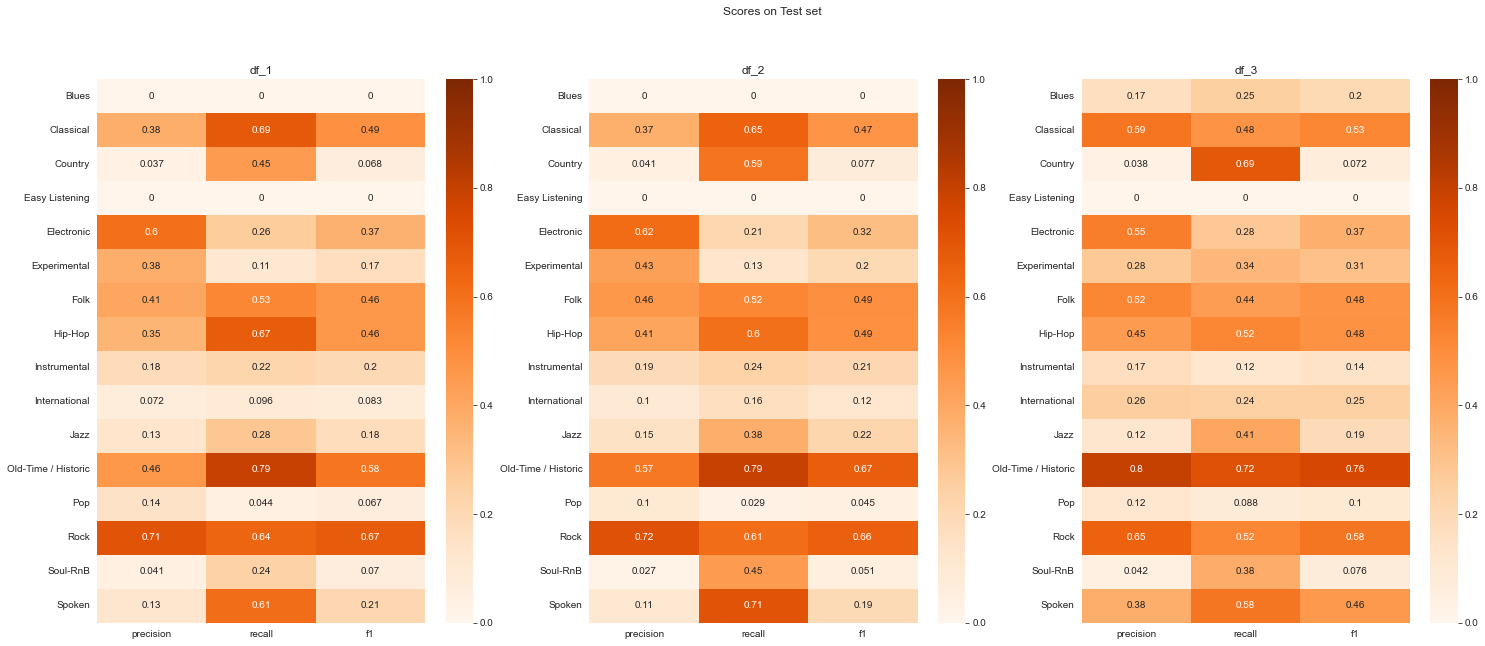

In [13]:
fig, axis = plt.subplots(1, 3, figsize=(25, 10))
fig.suptitle('Scores on Test set')
for i, (model_name, me) in enumerate(model_evaluations.items()):
    me.plot_metrics_per_class(ax=axis[i], on_set='validation', horizontal=False)
    axis[i].set_title(model_name)

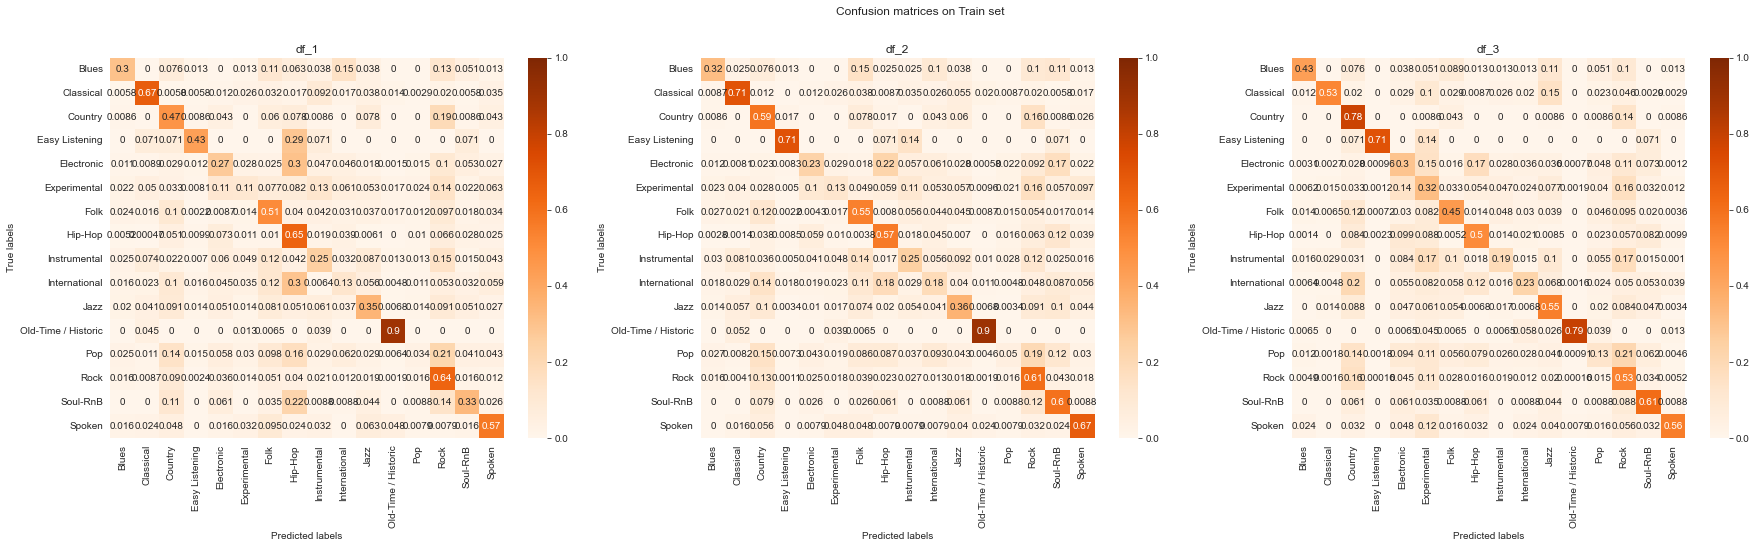

In [14]:
fig, axis = plt.subplots(1, 3, figsize=(30, 7))
fig.suptitle('Confusion matrices on Train set')
for i, (model_name, me) in enumerate(model_evaluations.items()):
    me.plot_confusion_matrix(ax=axis[i], on_set='train')
    axis[i].set_title(model_name)

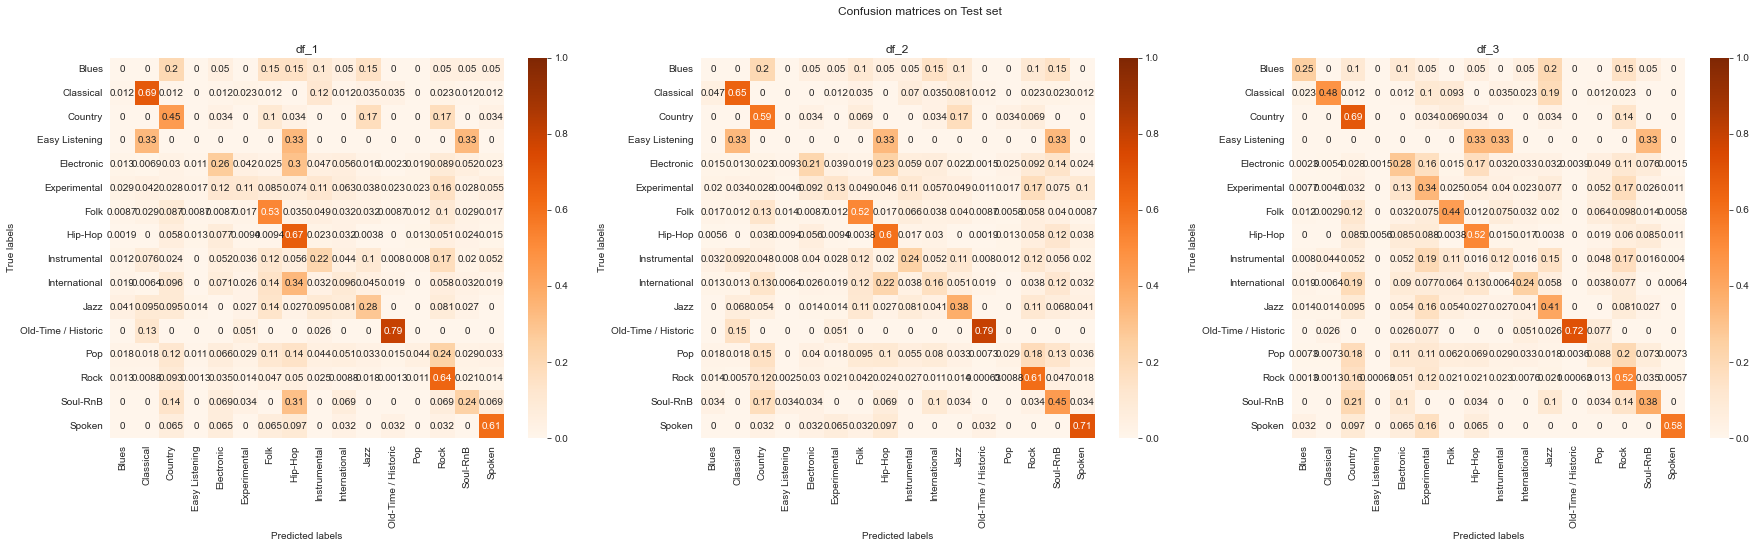

In [15]:
fig, axis = plt.subplots(1, 3, figsize=(30, 7))
fig.suptitle('Confusion matrices on Test set')
for i, (model_name, me) in enumerate(model_evaluations.items()):
    me.plot_confusion_matrix(ax=axis[i], on_set='validation')
    axis[i].set_title(model_name)

Using all features in the dataset provides the highest precision, while using only MFCC leads to the highest accuracy and recall. However, the results are very similar.
Another thing to notice is that the models tend to misclassify the "Easy Listening" genre as classical, hip-hop, instrumental, and soul-RnB,  (they never accurately predict the "easy listening" genre).

# 3. Model Confidence

Next we will see how confident the model is when classifying a track, by using the predicted probabilities.

In [16]:
gnb = models['df_1']
gnb_me = model_evaluations['df_1']

predicted_proba = pd.DataFrame(gnb.predict_proba(gnb_me.val_X), columns=gnb.classes_, index=gnb_me.val_X.index)

# For each row, assign the column whose value for the predicted probability is the highest
predicted_proba['genre'] = predicted_proba.idxmax(axis=1)

Note that the figures below do not indicate that the model has classified the tracks correctly. Rather, they show the level of confidence the model has in its classification of the samples (for example even if there are samples where the model is confident that they belong in the "Easy Listening" genre, none of the instances the model has classified as "Easy Listening" actually do belong in that genre).

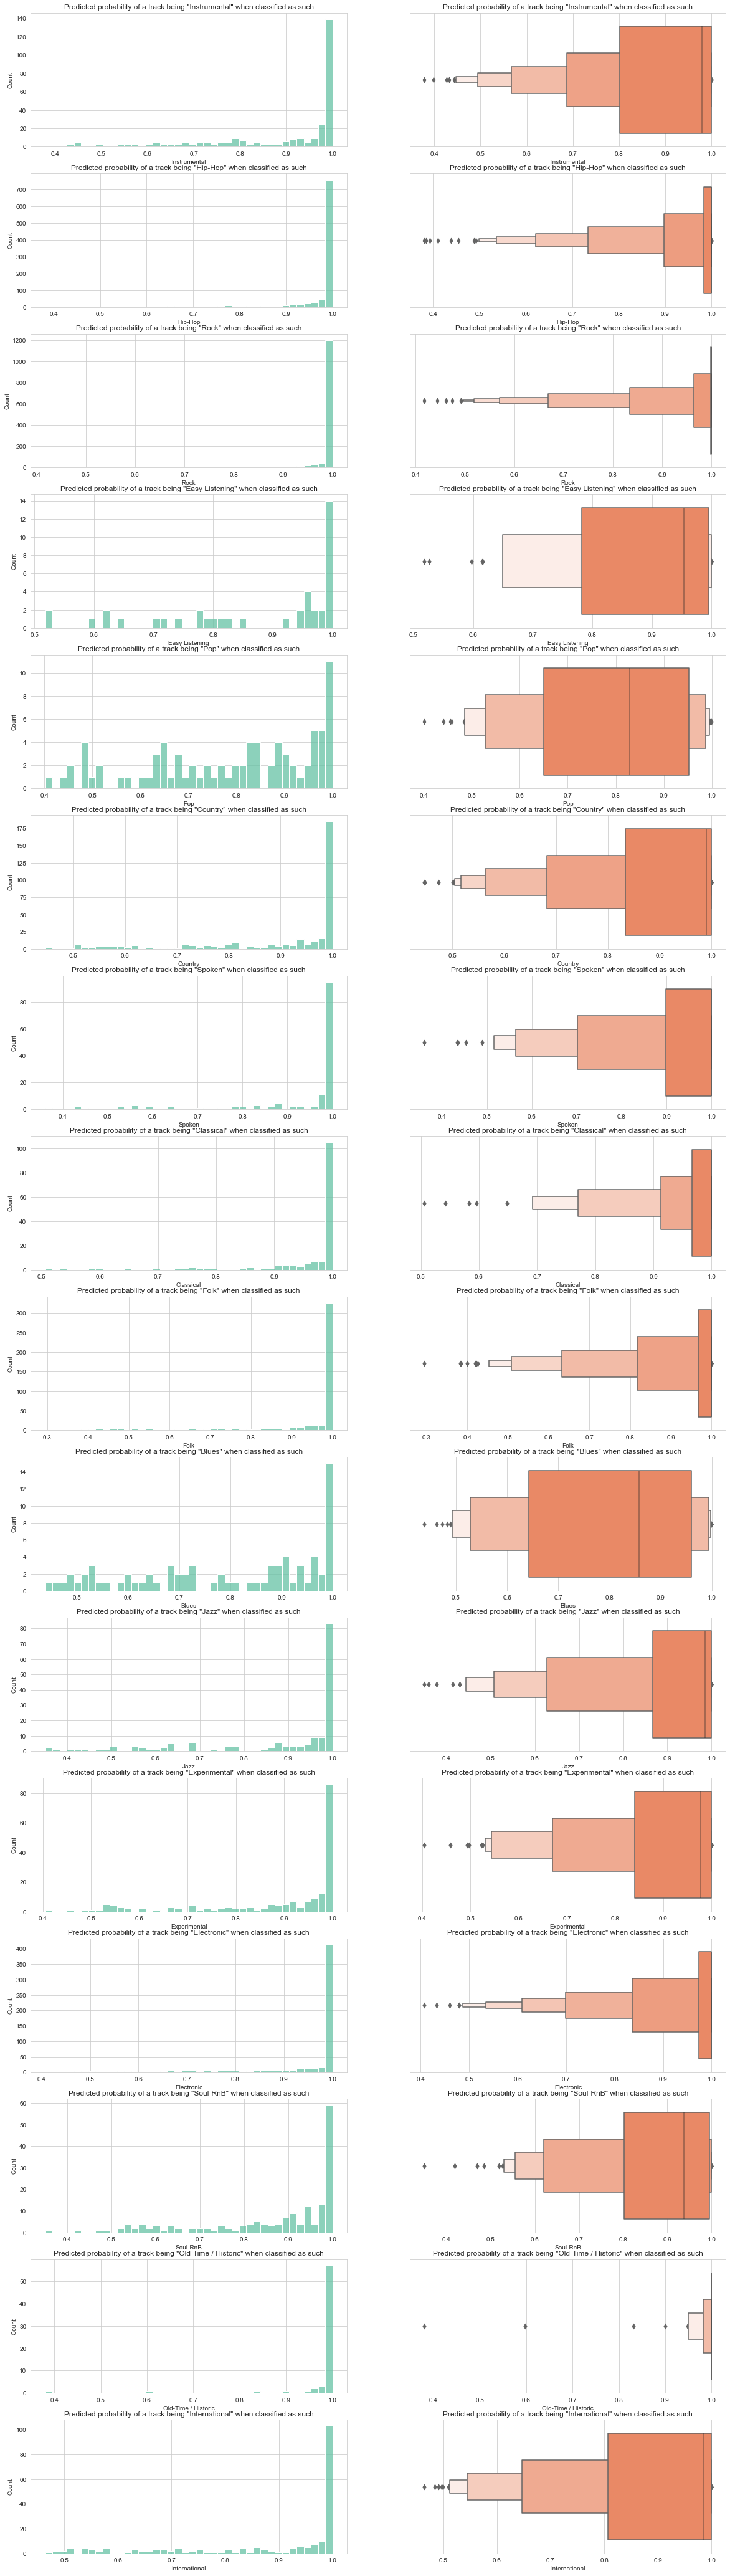

In [17]:
num_genres = predicted_proba['genre'].nunique()
ax_idxs = [(i, j) for i in range(num_genres) for j in range(2)]

fig, axs = plt.subplots(num_genres, 2, figsize=(20, 75))

k = 0
for genre in predicted_proba['genre'].unique():
    ax1_idx, ax2_idx = ax_idxs[k], ax_idxs[k + 1]
    ax1, ax2 = axs[ax1_idx[0]][ax1_idx[1]], axs[ax2_idx[0]][ax2_idx[1]]

    ax1.set_title(f'Predicted probability of a track being "{genre}" when classified as such')
    ax2.set_title(f'Predicted probability of a track being "{genre}" when classified as such')

    sns.histplot(x=predicted_proba[predicted_proba['genre'] == genre][genre], bins=40, ax=ax1)
    sns.boxenplot(x=predicted_proba[predicted_proba['genre'] == genre][genre], color='coral', ax=ax2)
    k += 2

We see that the model is generally not very confident when classifying a track as Easy Listening, Pop, Blues, Soul-RnB and International, which explains the results seen in the confusion matrix, as well as the precision, recall and f1 scores.

# 4. Conclusion
Despite the strong assumption that the class conditional densities $p(\mathbf{x}|y=c, \mathbf{\theta})$ follow a multivariate normal distribution with diagonal covariance matrices, the model was still able to capture some of the underlying patterns in the data.

One potential method for enhancing the model's performance would be to compute maximum a posteriori (MAP) estimates of the model's parameters, or alternatively use a Bayesian Naive Bayes approach. However, specifying prior probabilities for the parameters is a challenge, given the complexity of interpreting the features.

Additionally, the class imbalance in the data presents an issue, and experimenting with priors for the target variable could potentially enhance the results.

Overall, the outcomes of this model can serve as a solid baseline for constructing more complex models in the future.